In [1]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import re
import pandas as pd
import numpy as np
import string
import time
import math
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, random_split, Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [2]:
## Initialize needed variables and set up pipelines for tokenizations

train = pd.read_pickle('Preprocessing_Train.pkl')
X_train, X_test, y_train, y_test = train_test_split(train.document_text, train.label, test_size=0.25)

stop_words = stopwords.words('english')
non_neg_stop = [i for i in stop_words if "n't" not in i and "no" not in i]
lemma = WordNetLemmatizer()


def pos(x):
    if x.startswith('J'):
        return 'a'
    elif x.startswith('V'):
        return 'v'
    elif x.startswith('R'):
        return 'r'
    else:
        return 'n'
    
    
def tok(doc, non_neg=False, lemmatized=False):
    
    if non_neg:
        stop = non_neg_stop
    else:
        stop = stop_words
       
    tokens = re.split(r'\s', doc.lower())
    
    if lemmatized:
        pos_list = nltk.pos_tag(tokens)
        tokens = list(map(lambda x: lemma.lemmatize(x[0], pos(x[1])), pos_list))    

    tokens = [i for i in tokens if i not in stop]
    tokens = [i for i in tokens if len(re.findall(r'\w', i)) >= 2]
    tokens = [re.findall(r"\w[a-zA-Z0-9.-]*\w", i)[0] for i in tokens if re.findall(r"\w[a-zA-Z0-9.-]*\w", i)]
    
    return tokens


def get_voc_new(X, non_neg=True, lemmatized=True):
    
    voc = []
    token_list = []
    for i in X:
        tokens = tok(i, non_neg, lemmatized)
        token_list.append(tokens)
        voc += tokens
        
    voc = list(set(voc))
    
    return voc, token_list

In [3]:
voc, tk_list_train = get_voc_new(X_train, False, True)
voc_test, tk_list_test = get_voc_new(X_test, False, True)

## 此处 min_df 可调参

tfidf = TfidfVectorizer(min_df=10, vocabulary=voc)
vec_train = tfidf.fit_transform(X_train)
vec_test = tfidf.transform(X_test)

In [4]:
class _dataset(Dataset):
    
    def __init__(self, X, y):
        super(_dataset, self).__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y)
        
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
    def __len__(self):
        return len(self.X)
    
    
_train = _dataset(vec_train.toarray(), np.array(list(y_train)))
_test = _dataset(vec_test.toarray(), np.array(list(y_test)))

In [32]:
## 此处网络架构可更改

class MLP_model(nn.Module):
    
    def __init__(self):

        super(MLP_model, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv1d(1, 256, 10, 5),
            nn.ReLU(),
            nn.MaxPool1d(100, 100),
            nn.Linear(vec_train.shape[1], 500),
            nn.ReLU(),
            nn.Linear(500, 200),
            nn.ReLU(),
            nn.Linear(200, 50),
            nn.Sigmoid())

            
    def forward(self, x):
        return self.net(x)

In [33]:
def train_model(model, train_dataset, eval_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    
    history = {'train_loss': [], 'eval_loss': [], 'detail_train': [], 'detail_eval': []}
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

    model = model.to(device)
    save_loss = nn.BCELoss(reduction='none').to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        train_loss = 0
        eval_loss = 0
        detail_train = torch.zeros(50).to(device)
        detail_eval = torch.zeros(50).to(device)
        pred = []
        real = []
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            loss = Loss(out, y)
            save_train = save_loss(out, y).sum(0)
            
            op.zero_grad()
            loss.backward()
            op.step()
            
            train_loss += loss
            detail_train += save_train
            
        model.eval()
        with torch.no_grad():
            for X, y in eval_loader:
                X = X.to(device)
                y = y.to(device)
                out = model(X)
                loss = Loss(out, y)
                save_eval = save_loss(out, y).sum(0)
                detail_eval += save_eval
                eval_loss += loss
                pred.append(out.cpu())
                real.append(y.cpu())
                
        train_loss = (train_loss/len(train_loader)).item()
        eval_loss = (eval_loss/len(eval_loader)).item() 
        
        history['train_loss'].append(train_loss)
        history['eval_loss'].append(eval_loss)  
        history['detail_train'].append(detail_train.cpu().detach())
        history['detail_eval'].append(detail_eval.cpu().detach())  
        
        if not (epoch+1)%50:
            res = torch.cat(pred)
            tru = torch.cat(real)
            print(f'\nepoch {epoch+1}:\n')
            print(f"f1_score for 50 classes: {f1_score(tru, np.round(res), average='macro')}")
            print(classification_report(tru.view(-1), np.round(res).view(-1)))
            print(f'\nSpent time: {time.time()-start} seconds')
            
        
    print('Training complete!')
    
    return history

In [34]:
## 此处超参可调整

model_A = MLP_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 150
lr = 3e-4
batch_size = 128
norm = None
hist = train_model(model_A, _train, _test, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

Training start!

epoch 50:

f1_score for 50 classes: 0.7217252839505249
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98    111504
         1.0       0.88      0.63      0.74     11746

    accuracy                           0.96    123250
   macro avg       0.92      0.81      0.86    123250
weighted avg       0.95      0.96      0.95    123250


Spent time: 36.825878381729126 seconds

epoch 100:

f1_score for 50 classes: 0.7453096178736901
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98    111504
         1.0       0.88      0.66      0.76     11746

    accuracy                           0.96    123250
   macro avg       0.92      0.83      0.87    123250
weighted avg       0.96      0.96      0.96    123250


Spent time: 74.10175490379333 seconds

epoch 150:

f1_score for 50 classes: 0.7464108607917563
              precision    recall  f1-score   support

         0.0       0.97   

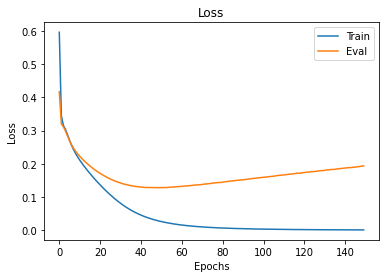

In [35]:
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['train_loss'], label='Train')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(hist['eval_loss'], label='Eval')
plt.legend();

In [22]:
count = torch.unique(torch.cat([i.argsort(descending=True)[:20] for i in hist['detail_train']]).cpu(), return_counts=True)

count_dic = dict(zip(list(map(lambda x: x.item(), count[0])), list(map(lambda x: x.item(), count[1]))))

dang = [i for i in count_dic if count_dic[i]>50]

label = pd.read_csv('Label_ID.csv').iloc[:, 1:]

label['freq'] = torch.Tensor(np.array(list(train.label))).sum(0)

loss_record = torch.stack([i.cpu().detach() for i in hist['detail_train']]).transpose(-2,-1)

loss_record[:, -100:].mean(-1).sort()

torch.return_types.sort(
values=tensor([350.7118, 355.1290, 378.2642, 402.6480, 407.1228, 411.4276, 418.5599,
        425.1306, 427.4203, 427.5400, 431.8841, 433.3044, 436.6442, 451.1245,
        453.7457, 468.3908, 470.9056, 472.2065, 489.3052, 491.3219, 491.9283,
        494.1530, 502.2462, 504.3842, 508.8891, 516.0683, 548.8818, 551.8469,
        553.8745, 556.7708, 563.2516, 568.1834, 570.2498, 575.2878, 586.4438,
        587.4977, 594.5275, 607.1110, 611.0286, 641.1893, 642.6041, 673.4567,
        696.0206, 696.3378, 706.4462, 706.9489, 733.0561, 735.7684, 736.5236,
        752.6345]),
indices=tensor([32,  4, 28, 45, 43, 36, 18, 26, 19, 49, 47, 15, 21, 17,  3, 11, 41,  1,
        16, 34,  8, 48, 33, 10, 37, 30,  2, 25, 31, 27, 40, 42,  6, 24, 14, 23,
        44,  7,  0, 38, 22, 35, 13,  5,  9, 39, 29, 12, 46, 20]))

In [27]:
dic = dict(zip(np.array(loss_record[:, -100:].mean(-1).sort().indices), 
               np.array(loss_record[:, -200:].mean(-1).sort().values)))

In [30]:
xx = pd.read_csv('new.csv')

In [31]:
xx['tfidf_loss'] = [dic[i] for i in range(50)]

In [32]:
xx.to_csv('new.csv')

In [23]:
def top_trash(top):
    return label.iloc[list(map(lambda x: x.item(), loss_record[:, -100:].mean(-1).argsort(descending=True)[:top]))]

lj = top_trash(10)

In [26]:
top_trash(50)

,label_idx,cat_name,freq
20,20,Information Filing,1387.0
46,46,Securities Sales,1737.0
12,12,Examinations,1742.0
29,29,Market Risk,1633.0
39,39,Regulatory Reporting,1042.0
9,9,Corporate Governance,958.0
5,5,Compliance Management,1391.0
13,13,Exemptions,1190.0
35,35,Powers and Duties,797.0
22,22,Legal,907.0


In [7]:
tst = pd.read_csv('datasolve-us/test.csv')

In [8]:
voc_final, _ = get_voc_new(train.document_text, False, True)
voc_tst, _ = get_voc_new(tst.document_text, False, True)


In [36]:
tfidf = TfidfVectorizer(min_df=10, vocabulary=voc_final)
vec_train = tfidf.fit_transform(train.document_text)
vec_test = tfidf.transform(tst.document_text)

In [37]:
_train = _dataset(vec_train.toarray(), np.array(list(train.label)))

In [50]:

class MLP_model(nn.Module):
    
    def __init__(self):

        super(MLP_model, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(vec_train.shape[1], 600),
            nn.ReLU(),
            nn.Linear(600, 50),
            nn.Sigmoid())

            
    def forward(self, x):
        return self.net(x)

In [51]:
def gg(model, train_dataset, device, norm=0.5,
                lr=0.0005, epochs=50, batch_size=256):
    

    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    
    if norm:
        Loss = nn.BCELoss(weight=train_.y.sum(axis=0)**-norm).to(device)

    else:
        Loss = nn.BCELoss().to(device)
        
    op = torch.optim.Adam(model.parameters(), lr=lr)
    
    print('Training start!')
    start = time.time()
    
    for epoch in range(epochs):
        
        model.train()
        
        for X, y in train_loader:
            X = X.to(device)
            y = y.to(device)
            out = model(X)
            loss = Loss(out, y)
            
            op.zero_grad()
            loss.backward()
            op.step()
            

            
        
    print('Training complete!')
    
    return None

In [52]:
model_A = MLP_model()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
epochs = 100
lr = 3e-4
batch_size = 128
norm = None
hist = gg(model_A, _train, device, norm,
                lr=lr, epochs=epochs, batch_size=batch_size)

Training start!
Training complete!


In [53]:
xxx = torch.Tensor(vec_test.toarray()).to(device)

with torch.no_grad():
    res = model_A(xxx)

rr = np.round(res.view(-1).cpu())
pd.DataFrame(rr, columns=['predictions']).to_csv('tfidf_0.csv')

In [18]:
res

tensor([[8.8509e-03, 2.7059e-03, 7.0272e-02,  ..., 6.6872e-03, 3.9784e-04,
         4.3600e-03],
        [3.3461e-03, 2.7921e-03, 4.5968e-03,  ..., 5.9466e-04, 1.7163e-03,
         2.9930e-04],
        [1.7893e-02, 2.9207e-01, 3.4137e-02,  ..., 4.1773e-03, 2.9484e-03,
         5.5475e-04],
        ...,
        [1.8921e-02, 2.5527e-04, 5.4045e-01,  ..., 1.3347e-02, 7.6063e-02,
         1.4060e-02],
        [2.4283e-03, 3.2208e-03, 5.3831e-03,  ..., 8.8511e-04, 9.5805e-02,
         2.0726e-03],
        [1.4874e-02, 2.7205e-02, 5.3003e-02,  ..., 2.5159e-03, 8.0766e-03,
         9.3991e-04]], device='cuda:0')

In [49]:
# t3 = pd.read_csv('try_3.csv')

# (torch.Tensor(np.array(t3.predictions)) == rr).float().mean()

## 150 epoch < original 50 epoch tfidf 1-layer 500 relu < 100 epoch
## 50 epoch tfidf 1-layer 300 relu
## 500-200 < 500